# Apprentissage de paramètres par maximum de vraisemblance
Dans ce TME, l'objectif est d'apprendre grâce à l'estimateur de maximum de vraisemblance les paramètres de lois normales à partir d'un ensemble de données. Ces lois normales seront ensuite exploitées pour faire de la classification (comme nous l'avions vu en cours avec les images de désert, forêt, mer et paysages enneigés).

Ici, notre base de données d'apprentissage est la base USPS. Celle-ci contient les images réelles de chiffres provenant de codes postaux écrits manuellement et scannés par le service des postes américain. Ces données scannées ont été normalisées de manière à ce qu'elles soient toutes des images de 16x16 pixels en teintes de gris, cf. Le Cun et al., 1990:

Y. LeCun, O. Matan, B. Boser, J. S. Denker, et al. (1990) *Handwritten zip code recognition with multilayer networks*. In ICPR, volume II, pages 35–40.

Voici quelques exemples d'images de cette base : 

<img src="usps.png" title="Quelques exemples">


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

## Chargement des données et premières visualisations

Nous utiliserons la librairie pickle qui permet de sérialiser les objets en python (ie, les sauver et les charger très facilement).
Une fois les données chargées, nous allons étudier très rapidement la distribution des classes, visualiser une imagette de chiffre et comprendre l'encodage de ces chiffres.

(array([488., 412., 311., 260., 306., 244., 261., 282., 224., 281.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <BarContainer object of 10 artists>)

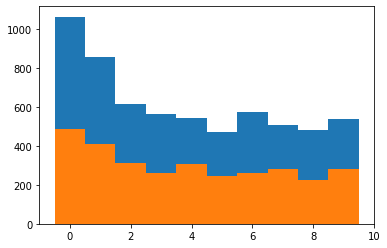

In [2]:
# Chargement des données
data = pkl.load(open("usps.pkl",'rb')) 
# data est un dictionnaire contenant les champs explicites X_train, X_test, Y_train, Y_test
X_train = np.array(data["X_train"],dtype=float) # changement de type pour éviter les problèmes d'affichage
X_test = np.array(data["X_test"],dtype=float)
Y_train = data["Y_train"]
Y_test = data["Y_test"]

# visualisation de la distribution des étiquettes (dans les 10 classes de chiffres)
plt.figure()
plt.hist(Y_train, np.linspace(-0.5,9.5,11))
plt.hist(Y_test, np.linspace(-0.5,9.5,11))
#plt.savefig("distr_classes.png")

(6229, 256)
(3069, 256) (6229,) (3069,)


Text(0.5, 1.0, 'Image de : 6')

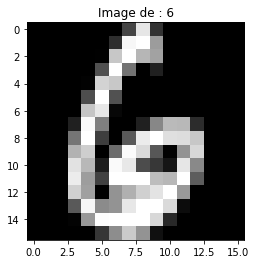

In [3]:
# prise en main des matrices X, Y
print(X_train.shape)
# 6229 images composées de 256 pixels (image = 16x16)
print(X_test.shape,Y_train.shape, Y_test.shape)

# Affichage de l'image 18 de la base de données et récupération de l'étiquette associée:
# (1) remise en forme de la ligne de 256 pixels en 16x16
# (2) affichage avec imshow (en niveaux de gris)
# (3) récupération de l'étiquette dans Y_train

plt.figure()
plt.imshow(X_train[18].reshape(16,16),cmap="gray")
plt.title("Image de : {}".format(Y_train[18]))

In [4]:
# analyse des valeurs min et max, recherche du nombre de niveaux de gris dans les images:
print(X_train.min(),X_train.max() )
print("niveaux de gris : ", len(np.unique(X_train))) 

0.0 2.0
niveaux de gris :  2001


# A. Apprentissage et évaluation d'un modèle gaussien naïf

## A1- Maximum de vraisemblance 

Nous allons étudier la distribution de probabilité des teintes de gris des images (en fait, nous allons étudier sa fonction de densité car on travaille sur des variables aléatoires continues) . Nous allons faire l'hypothèse (certes un peu forte mais tellement pratique) que, dans chaque classe, les teintes des pixels sont mutuellement indépendantes. 

Autrement dit, si $X_i, i\in \{0,...,255\}$ représente la variable aléatoire "intensité de gris du ième pixel", alors $p(X_0,…,X_{255})$ représente la fonction de densité des teintes de gris des images de la classe et: 

$$p(X_0,,…,X_{255})=\prod_{i=0}^{255} p(X_i)$$

Ainsi, en choisissant au hasard une image dans l'ensemble de toutes les images possibles de la classe, si celle-ci correspond au tableau `np.array([x_0,...,x_255])`, où les $x_i$ sont des nombres réels compris entre 0 et 2, alors la valeur de la fonction de densité de l'image est égale à $p(x_0,...,x_{255}) = \prod^{255}_{i=0}p(x_i)$. 

Nous allons de plus supposer que chaque $X_i$ suit une distribution normale de paramètres $(μ_i,σ^2_i)$. Autrement dit, $$\forall i\in\{0,...,255\}, X_i \sim {\cal N}(μ_i,σ^2_i)$$ 

Par maximum de vraisemblance, estimez, pour une classe donnée, l'ensemble des paramètres $(μ_0,…,μ_{255})$ et $(σ^2_0,…,σ^2_{255})$ pour chaque classe (chiffre de 0 à 9). Pour cela, écrivez une fonction `learnML_parameters : float np.array x float np.array -> float np.array x float np.array` qui, étant donné le tableau d'images , renvoie un couple de tableaux, le premier élément du couple correspondant à l'ensemble des $μ_i$ et le 2ème à l'ensemble des $σ^2_i$. C'est-à-dire que `learnML_parameters` renverra deux matrices:
$$ mu \in \mathbb R^{10 \times 256}, sig \in \mathbb R^{10 \times 256}$$

* mu contient les moyennes des 256 pixels pour les 10 classes
* std contient les écarts-types des 256 pixels pour les 10 classes



In [5]:
def learnML_parameters(X,Y):
    """
    Estime par maximum de vraissemblance, pour une classe donnée, l'ensemble des moyennes 
    et écrarts-types pour chaque classe.
    param X : float np.array (6229 images composées de 256 pixels)
    param Y : float np.array (classe, comprise entre 0 et 9, des 6229 images)
    return mu, sig : deux matrices contenant respectivement les moyennes et 
                     les écarts-types des 256 pixels pour les 10 classes.
    """
    mu = np.zeros((10,256)) #moyenne
    sigma = np.zeros((10,256)) #ecart-type
    
    for classe in range(10): #pour chaque classe 
        liste_img = X[Y==classe] #on récupère toutes les images de la classe 
        
        for pix in range(256): #pour chaque pixel des images
            #on récupère le pix_ième pixel pour chaque image de la classe
            liste_pix = [ img[pix] for img in liste_img ]
            mu[classe][pix] = np.mean(liste_pix) #calcul de la moyenne
            sigma[classe][pix] = np.std(liste_pix) #calcul de l'ecart-type
    
    return mu, sigma

In [6]:
mu,sig = learnML_parameters ( X_train, Y_train )
print(mu.shape, sig.shape) # doit donner (10, 256) (10, 256)

(10, 256) (10, 256)


Check: pour la classe 0, les paramètres doivent être les suivants
```
mu[0]=
[1.53774208e-03 4.46785940e-03 1.71216078e-02 6.31194048e-02
 1.84061642e-01 4.71391665e-01 8.97640989e-01 1.15019928e+00
 ...
 1.42675380e+00 1.03130694e+00 5.32240296e-01 1.74166387e-01
 3.57644515e-02 5.52804884e-03 4.36592998e-04 0.00000000e+00]
sig[0]=
[5.01596286e-02 7.93695089e-02 1.46489017e-01 2.65522337e-01
 4.42306204e-01 6.35148001e-01 7.40462105e-01 7.48387032e-01
 ...
 6.62741331e-01 6.75677391e-01 5.86224763e-01 3.56460503e-01
 1.71512333e-01 5.67475697e-02 1.20193571e-02 0.00000000e+00]
```

In [7]:
print(mu[0], sig[0])

[1.53774208e-03 4.46785940e-03 1.71216078e-02 6.31194048e-02
 1.84061642e-01 4.71391665e-01 8.97640989e-01 1.15019928e+00
 1.02070900e+00 6.16785408e-01 2.50766353e-01 8.09903122e-02
 1.49310824e-02 3.87033274e-03 1.70898437e-04 0.00000000e+00
 2.35601434e-03 7.93762565e-03 5.18573940e-02 2.00940178e-01
 5.59411980e-01 1.10202446e+00 1.53532559e+00 1.66378367e+00
 1.60174400e+00 1.37845195e+00 9.19353768e-01 4.15479248e-01
 1.22346858e-01 3.01527050e-02 4.24372534e-03 5.63428995e-06
 5.88210737e-03 3.00679919e-02 1.45009354e-01 4.68428296e-01
 9.87103163e-01 1.46020945e+00 1.63103905e+00 1.59445846e+00
 1.52785712e+00 1.52155705e+00 1.36630499e+00 9.33882722e-01
 4.29464169e-01 1.16865928e-01 2.02650169e-02 1.02089895e-03
 7.91202062e-03 6.88018163e-02 3.30783411e-01 8.24194929e-01
 1.31254975e+00 1.54256605e+00 1.44943446e+00 1.21191395e+00
 1.09220056e+00 1.22655949e+00 1.39070742e+00 1.27821441e+00
 8.46682745e-01 3.48925595e-01 8.07226924e-02 4.64439750e-03
 1.59532081e-02 1.766754

## A2- Log-vraisemblance d'une image pour une classe

Écrivez une fonction `log_likelihood : float np.array x float np.array x float np.array -> float` qui, étant donné une image (donc un tableau de 256 nombres réels) et un couple de paramètres `( array ( [μ0,…,μ255] ), array ( [σ20,…,σ255] ) )`, renvoie la log-vraisemblance qu'aurait l'image selon cet ensemble de $μ_i$ et $σ_i$ (correspondant à une classe de chiffre). Rappelez-vous que (en mettant $-\frac{1}{2}$ en facteur) : 

$$\log(p(x_0,\cdots,x_{255})=\sum_{i=0}^{255} \log p(x_i)=-\frac{1}{2}\sum_{i=0}^{255} \left[ \log(2\pi \sigma^2_i) + \frac{(x_i-\mu_i)^2}{\sigma_i^2} \right]$$

Notez que le module `np` contient une constante `np.pi` ainsi que toutes les fonctions mathématiques classiques directement applicables sur des vecteurs. Vous pouvez donc éventuellement coder la ligne précédente sans boucle, en une ligne.

**Attention**: dans la matrice `sig` calculée dans la question précédente, pour certains pixels de certaines classes, la valeur de $σ^2$ est égale à $0$ (toutes les images de la base d'apprentissage avaient exactement la même valeur sur ce pixel). 
* cette valeur pose problème dans le calcul précédent (division par 0)
* Réfléchir à différente manière de traiter ce problème:
 * faible valeur par défaut de $\sigma$ reflétant une variance très faible mais évitant la division par 0 (usage de  `np.maximum`par exemple)
 * vraisemblance de 1 pour le ou les pixels impactés

In [8]:
# on utilisera dans le suite le paramètre defeps: 
#    positif, il donne la valeur minimale d'écart type
#    = -1, il faut prendre une vraisemblance de 1 pour les pixels concernés
def log_likelihood(img, mu, sig, defsig = 1e-5):
    """
    Renvoie la log-vraissemblance d'une image
    param img : float np.array (image)
    param mu : float np.array (moyenne)
    param sig : float np.array (ecart-type)
    return  log_vraissemblance : float
    """
    if (defsig==-1): 
        sig_fix = np.where(sig!=0.0, sig, 1.0)
        return -(1/2) * np.sum(np.where(sig!=0 , np.log(2.0 * np.pi * sig_fix**2) + (img - mu)**2 / sig_fix**2 , 0.0))
    
    else: 
        sig_fix = np.where(sig!=0.0, sig, defsig)
        return -(1/2) * np.sum(np.log(2.0 * np.pi * sig_fix**2) + (img - mu)**2 / sig_fix**2 )

In [9]:
print("Cas avec une valeur par défaut de 1e-5 pour les sigmas nuls :")
print(log_likelihood(X_train[0], mu[0], sig[0])) 
# vraisemblance de l'image 0 selon les paramètres de la classe 0

print([log_likelihood(X_train[0], mu[i], sig[i]) for i in range(10)]) 
# vraisemblance de l'image 0 pour toutes les classes


print("\nCas avec une vraissemblance de 1 pour les pixels problématiques :")
print(log_likelihood(X_train[0], mu[0], sig[0],-1)) 
# vraisemblance de l'image 0 selon les paramètres de la classe 0

print([log_likelihood(X_train[0], mu[i], sig[i],-1) for i in range(10)]) 
# vraisemblance de l'image 0 pour toutes les classes

Cas avec une valeur par défaut de 1e-5 pour les sigmas nuls :
-90.69963035168726
[-90.69963035168726, -231211311074.5327, -364.83171019851994, -487.0108554487582, -513.1280647451556, -387.75946984197947, -59610.117733618186, -75567222244.77489, -271.9805426163888, -857252055.4774221]

Cas avec une vraissemblance de 1 pour les pixels problématiques :
-111.88760421521837
[-111.88760421521837, -1716629080.9897835, -364.83171019851994, -487.0108554487582, -544.9100255404522, -387.75946984197947, -59747.83956373114, -581523.2639945268, -303.76250341168543, -13497.825910916888]


Check : le code ci-dessus avec une valeur par défaut de $1e-5$ pour les sigmas nuls doit donner:
```
-90.69963035168726
```
puis pour toutes les classes:
```
[-90.69963035168726, -231211311074.5327, -364.8317101985202, -487.01085544875843, -513.128064745155, -387.75946984198, -59610.117733618186, -75567222244.77489, -271.980542616389, -857252055.4774221]
```

Avec une vraisemblance de 1 pour les pixels problématiques:
```
[-111.88760421521835, -1716629080.989729, -364.83171019852006, -487.01085544875855, -544.9100255404516, -387.7594698419803, -59747.8395637312, -581523.2639945432, -303.762503411686, -13497.825910916881]
```

## A3- Classification d'une image
Écrire une fonction `classify_image : float np.array x float np.array x float np.array -> int` qui, étant donnée une image et l'ensemble de paramètres déterminés dans les questions précédentes, renvoie la classe la plus probable de l'image, c'est-à-dire celle dont la log-vraisemblance est la plus grande.

In [10]:
def classify_image(img, mu, sig, defeps=1e-5):
    """
    Renvoie la classe la plus probable de l'image (log-vraissemblance la plus élevée) d'une image
    Renvoie la log-vraissemblance d'une image
    param img : float np.array (image)
    param mu : float np.array (moyenne)
    param sig : float np.array (ecart-type)
    return  classe : la classe la plus probable
    """
    log_vraiss_classes = [log_likelihood(img, mu[i], sig[i], defeps) for i in range(10)]
    return np.argmax(log_vraiss_classes)

In [11]:
# check
classify_image(X_train[0], mu, sig, -1)
# l'image 0 est de la classe 0

0

## A4- Classification de toutes les images
Écrire une fonction `classify_all_images : float np.array x float np.array x float np.array -> float np.array` qui, étant donné un tableau $X$ des images ($N \times 256$) et l'ensemble de paramètres déterminés dans les questions précédentes, renvoie un tableau $\hat Y$ qui donne la prédiction de classe pour toutes les images

In [12]:
def classify_all_images(X, mu, sig, defeps=1e-5):
    """
    Renvoie la prédiction de classe pour toutes les images de X
    param X : tableau des images (Nx256)
    param mu : float np.array (moyenne)
    param sig : float np.array (ecart-type)
    return  Y : la prédiction de classe pour chaque image de X
    """    
    return np.asarray([ classify_image( X[i], mu, sig, defeps) for i in range(len(X)) ])

In [13]:
# check
Y_train_hat = classify_all_images(X_train, mu, sig, -1)

print(Y_train_hat) # doit rendre: [0 9 7 ... 6 3 2]

[0 9 7 ... 6 3 2]


## A5-Matrice de confusion et affichage du résultat des classifications

La matrice de confusion est de la forme $C \times C$ où $C$ est le nombre de classe. Les lignes sont les vraies classes, les colonnes sont les classes prédites. Chaque case (i,j) contient le nombre d'images correspondant à la vraie classe i et à la prédiction j.
Si votre classifieur est performant, vous devriez observer des pics sur la diagonale. 

La fonction `matrice_confusion(Y, Y_hat)` prend en argument un vecteur d'étiquettes réelles et un vecteur de même taille d'étiquettes prédites et retourne la matrice de confusion.

Vous devriez obtenir une matrice de la forme:
<img src="mat_conf_train.png" title="Matrice de confusion">

In [14]:
def matrice_confusion(Y, Y_hat):
    """"
    Retourne la matrice de confusion
    param Y : vecteur d'étiquettes réelles
    param Y_hat : vecteur d'étiquettes prédites
    return M : la matrice de confusion
    """
    M = np.zeros( (len(np.unique(Y)), len(np.unique(Y))) ) #prend deux fois le nombre de classes dans Y au cas où on n'aurait jamais prédit cette classe dans Y_hat
    
    for i in range(len(Y)) : 
        M[Y[i]][Y_hat[i]] += 1
    
    return M

Taux de bonne classification: 0.8099213356879114


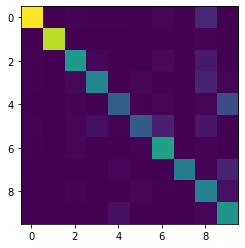

In [15]:
# affichage de la matrice de confusion
m = matrice_confusion(Y_train, Y_train_hat)

print("Taux de bonne classification: {}".format(np.where(Y_train == Y_train_hat, 1, 0).mean()))

plt.figure()
plt.imshow(m)

## A6- Ensemble d'apprentissage, ensemble de test

Dans la procédure que nous avons suivie jusqu'ici, nous avons triché. Les mêmes données servent à apprendre les paramètres et à évaluer le modèle. Evidemment, le modèle est parfaitement adapté et les performances sur-estimées.

Afin de réduire ce biais, nous allons maintenant évaluer les performances sur les données de test. Les performances devraient être plus basses... Mais plus réalistes.

Effectuer ces calculs et afficher le taux de bonne classification et la matrice de confusion.

**Attention:** il faut donc utiliser les paramètres appris sur de nouvelles données sans réapprendre des paramètres spécifiques sinon ça ne marche pas

Afin de mieux comprendre les erreurs (et de vérifier vos connaissances sur numpy): afficher une image de chiffre mal classée, son étiquette prédite et son étiquette réelle. 
Normalement, vous devez retrouver automatiquement que le premier chiffre mal classé est l'image 10:

<img src="bad_classif.png" title="exemple d'erreur">

Taux de bonne classification: 0.7934180514825676


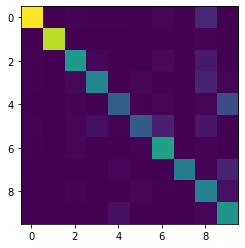


Affichage d'une image mal classée : 

classe reelle :  5
classe estimee :  6


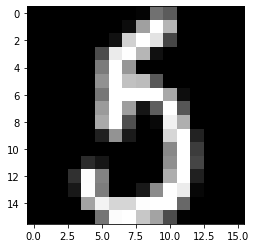

In [16]:
#estimation 
Y_test_hat = classify_all_images(X_test, mu, sig, -1)

# affichage de la matrice de confusion
m_test = matrice_confusion(Y_test, Y_test_hat)
print("Taux de bonne classification: {}".format(np.where(Y_test == Y_test_hat, 1, 0).mean()))
plt.figure()
plt.imshow(m)
plt.show()

# affichage image mal classée
print("\nAffichage d'une image mal classée : \n")
images_mal_classees = np.where(Y_test!=Y_test_hat)
image_mal_classee = images_mal_classees[0][0] #on récupère la premiere image mal classée
print("classe reelle : ", Y_test[image_mal_classee])
print("classe estimee : ", Y_test_hat[image_mal_classee])
plt.figure()
plt.imshow(X_test[image_mal_classee].reshape(16,16), cmap="gray")
plt.show()


# Autres modélisations possibles pour les images

## B. Modélisation par une loi de Bernoulli

Soit les indices $i$ donnant les images et les indices $j$ référant aux pixels dans l'image, nous cherchons à déterminer la probabilité d'illumination d'un pixel $j$ pour une collection d'image (d'une seule classe, par exemple les $0$).

Collection de $0$:
$$ X = \{\mathbf{x_i}\}_{i = 1,\ldots, N}, \qquad \mathbf{x_i} \in \{0,1\}^{256}$$

Modélisation de la variable de Bernoulli $X_j$, valeur du pixel $j$ en écriture factorisée:
$$ p(X_j = x_{ij}) = p_j^{x_{ij}} (1-p_j)^{(1-x_{ij})} = \left\{
\begin{array}{ccc}
p_j & \mbox{ si } x_{ij} = 1 \\
1-p_j & \mbox{ si } x_{ij} = 0 \\
\end{array}
\right.$$

Expression de la vraisemblance

Maximisation de la vraisemblance $\Rightarrow$ $\nabla_{\theta} \mathcal L(X, \theta) = 0$:

$$p_j^\star = \frac{\sum_i x_{ij}}{N} $$

Intuitif: nombre de $1$ pour le pixel $j$ divisé par le nombre d'image = pourcentage d'illumination du pixel $j$

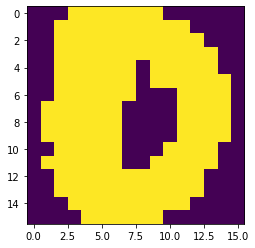

In [17]:
# binarisation des images pour coller avec l'hypothèse de Bernoulli:

Xb_train = np.where(X_train>0, 1, 0)
Xb_test  = np.where(X_test>0, 1, 0)

# affichage d'une image binaire:
plt.figure()
plt.imshow(Xb_train[0].reshape(16,16))

### B-1: Ecrire la fonction d'apprentissage des paramètres qui retourne la matrice theta suivante:

$$ \theta^\star = 
 \left[
 \begin{array}{ccc}
     [p_0^\star, \ldots, p_{255}^\star] & \mbox{Paramètres optimaux de la classe 0 au sens du max de vraisembalnce} \\
     [p_0^\star, \ldots, p_{255}^\star] & \mbox{Paramètres optimaux de la classe 1 au sens du max de vraisembalnce} \\
\vdots & \\
     [p_0^\star, \ldots, p_{255}^\star] & \mbox{Paramètres optimaux de la classe 9 au sens du max de vraisembalnce} \\
\end{array}
 \right]
 $$
 
 Il faut ensuite calculer les :
 $$ \log p (\mathbf{x_i} | \theta^{(c)}) = \sum_j \log p(X_j = x_{ij})  = \sum_j {x_{ij}} \log p_j + {(1-x_{ij})}\log(1-p_j)$$
 
 Faire passer les $N$ images dans les $C$ modèles donne un tableau de la forme :
 $$ \log p (X | \theta) =  \left[
 \begin{array}{cccc}
 \log p (\mathbf{x_0} | \theta^{(0)}) &  \log p (\mathbf{x_0} | \theta^{(1)}) & \ldots &  \log p (\mathbf{x_0} | \theta^{(9)}) \\
 & \vdots & \\
 \log p (\mathbf{x_N} | \theta^{(0)}) &  \log p (\mathbf{x_N} | \theta^{(1)}) & \ldots &  \log p (\mathbf{x_N} | \theta^{(9)}) \\
  \end{array}
 \right]
 $$
 
 Chaque ligne donne pour une image sa probabilité d'appartenance à chaque classe $c$.
 Un argmax par ligne donne une estimation de la classe.

In [18]:
def learnBernoulli ( X,Y ):
    """
    Calcule la matrice des paramètres optimaux pour chaque classe
    param X : float np.array (toutes les images avec leurs 256 pixels)
    param Y : float np.array (classe des images)
    return theta : matrice des paramètres optimaux pour chaque classe (au sens de max de vraissemblance)
    """
    classes = np.unique(Y) #récupère toutes les classes distinctes de Y
    theta = np.zeros((len(classes), 256))
    
    for classe in classes : 
        for pix in range(256):
            theta[classe][pix] = X[:,pix][Y==classe].sum() / np.count_nonzero(Y==classe) 

    return theta

In [19]:
theta = learnBernoulli ( Xb_train,Y_train )
print(theta.shape)
print(theta)

(10, 256)
[[0.00093897 0.00657277 0.03192488 ... 0.02347418 0.00375587 0.        ]
 [0.         0.         0.         ... 0.00233372 0.         0.        ]
 [0.01941748 0.05987055 0.13430421 ... 0.27993528 0.20711974 0.11326861]
 ...
 [0.06666667 0.16078431 0.2745098  ... 0.         0.         0.        ]
 [0.01033058 0.05371901 0.1322314  ... 0.01446281 0.00206612 0.        ]
 [0.0037037  0.0037037  0.01111111 ... 0.00555556 0.00185185 0.        ]]


Check du résultat précédent:
```
(10, 256)
[[0.00093897 0.00657277 0.03192488 ... 0.02347418 0.00375587 0.        ]
 [0.         0.         0.         ... 0.00233372 0.         0.        ]
 [0.01941748 0.05987055 0.13430421 ... 0.27993528 0.20711974 0.11326861]
 ...
 [0.06666667 0.16078431 0.2745098  ... 0.         0.         0.        ]
 [0.01033058 0.05371901 0.1322314  ... 0.01446281 0.00206612 0.        ]
 [0.0037037  0.0037037  0.01111111 ... 0.00555556 0.00185185 0.        ]]
```

### B-2: Ecrire ensuite une fonction de calcul de la vraisemblance d'une image par rapport à ces paramètres

**Attention** $log(0)$ n'est pas défini et $log(1-x)$ avec $x=1$ non plus ! 
La solution à ce problème est assez simple, il suffit de seuiller les probabilités d'illumination entre $\epsilon $ et $1-\epsilon$.

In [20]:
def logpobsBernoulli(X, theta):
    """
    Calcule la vraissemblance d'une image par rapport aux paramètres optimaux pour chaque classe
    param X : float np.array (image de 256 pixels)
    param theta : matrice des paramètres optimaux pour chaque classe (au sens de max de vraissemblance)
    return logpobs : vraissemblance d'une image par rapport aux paramètres optimaux
    """
    eps=1e-4
    theta = np.where(theta==0, eps, theta) #si theta vaut 0 alors p vaut eps
    theta = np.where(theta==1, 1-eps, theta) #si theta vaut 1 alors p vaut 1-eps
    return np.asarray([ np.sum( X*np.log(theta[k]) + (1-X) * np.log(1-theta[k]) ) for k in range(10) ])

In [21]:
logpobsBernoulli(Xb_train[0], theta)
# check avec un epsilon = 1e-4 : 


array([ -84.92517398, -742.65796653, -171.38766957, -175.31753619,
       -216.95715849, -161.36508121, -208.21533436, -360.17024632,
       -172.16285293, -287.87685778])

### B-3: Evaluer ensuite vos performances avec les mêmes méthodes que précédemment

Taux de bonne classification: 0.8533724340175953


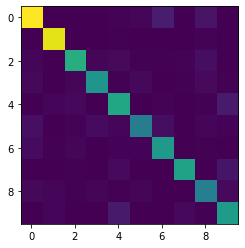

In [22]:
Y_test_hat = [np.argmax(logpobsBernoulli(Xb_test[i], theta)) for i in range (len(Xb_test))]

m = matrice_confusion(Y_test, Y_test_hat)

print("Taux de bonne classification: {}".format(np.where(Y_test == Y_test_hat, 1, 0).mean()))

plt.figure()
plt.imshow(m)

# C. Modélisation des profils de chiffre

Comme expliquer dans le TD 2, il est possible de jouer avec les profils des images: chaque image est alors séparée en 16 lignes et pour chaque ligne, nous modélisons l'apparition du premier pixel allumé avec une loi géométrique.
Pour plus de simplicité, nous vous donnons ci-dessous la fonction de transformation de la base d'image et son application.

In [23]:
################################################################################
# modelisation geometrique
def transfoProfil(X):
    x2 = []
    for x in X:
        ind = np.where(np.hstack((x.reshape(16, 16), np.ones((16,1))))>0.3)
        x2.append( [ind[1][np.where(ind[0] == i)][0] for i in range(16)])
    return np.array(x2)

Xg_train = transfoProfil(Xb_train)
Xg_test  = transfoProfil(Xb_test)

In [24]:
print(Xg_train[0]) # [3 2 2 2 2 2 2 1 1 1 2 1 2 2 3 4]
# une image est maintenant représentée par 16 entiers

[3 2 2 2 2 2 2 1 1 1 2 1 2 2 3 4]


### C-123: Ecrire les fonctions d'apprentissage des paramètres et de calcul de la vraisemblance avec cette modélisation

[ -8.59383056 -30.91829135 -21.49092763 -29.19427401 -25.74819885
 -24.9698666  -20.39913243 -32.67620668 -24.64316047 -28.58230496]

Taux de bonne classification: 0.6448354512870642


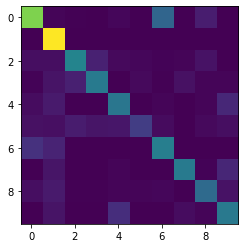

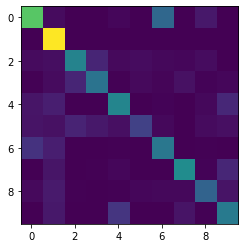

In [25]:
def learnGeom (X,Y):
    """
    Apprentissage des paramètres
    param X : float np.array (6229 images représentées par 16 entiers correspondants au premier pixel allumé d'une ligne)
    param Y : float np.array (classe des images)
    return theta : matrice des paramètres optimaux pour chaque classe (au sens de max de vraissemblance)
    """
    classes = np.unique(Y)
    theta = np.zeros((len(classes), 16))
   
    for classe in classes :
        for pix in range(16):
            theta[classe][pix] = np.count_nonzero(Y==classe)/X[:, pix][Y==classe].sum() 
   
    return theta
   
def logpobsGeom(X, theta):
    """
    Calcule la vraissemblance d'une image par rapport aux paramètres optimaux pour chaque classe
    param X : float np.array (image décrite par le premier pixel allumé de chaque ligne)
    param theta : matrice des paramètres obtenus pour chaque classe (au sens de maximum de vraissemblance)
    return logpobs : vraissemblance d'une image par rapport aux paramètres optimaux
    """
    eps=1e-4
    theta = np.where(theta==0, eps, theta) #si theta vaut 0 alors p vaut eps
    theta = np.where(theta==1, 1-eps, theta) #si theta vaut 1 alors p vaut 1-eps

    n=len(X) #16
    return np.asarray([ np.sum( np.log(theta[k]) + (X-1) * np.log(1-theta[k]) ) for k in range(10) ])
   
theta = learnGeom(Xg_train, Y_train)
print(logpobsGeom(Xg_test[1], theta))

Y_train_hat = [np.argmax(logpobsGeom(Xg_train[i], theta)) for i in range (len(Xg_train))]
Y_test_hat  = [np.argmax(logpobsGeom(Xg_test[i], theta)) for i in range (len(Xg_test))]

ma = matrice_confusion(Y_train, Y_train_hat)
mt = matrice_confusion(Y_test, Y_test_hat)

print("\nTaux de bonne classification: {}".format(np.where(Y_test == Y_test_hat, 1, 0).mean()))

plt.figure()
plt.imshow(ma)
plt.figure()
plt.imshow(mt)

# D. Maximum a posteriori

Etant donné les distributions non uniformes de classes observées sur le jeu de donnée:

<img src="distr_classes.png" title="Distribution des classes">

Calculer les maxima a posteriori avec les différentes modélisations et vérifier s'il y a un gain en performance avec cette modélisation.

In [26]:
# récupération des probabilités a priori sur les données d'apprentissage:
p= np.histogram(Y_train, np.linspace(-0.5,9.5,11))
p = p[0] / p[0].sum()
print(p)



[0.17097447 0.13758228 0.09921336 0.09054423 0.08765452 0.0757746
 0.09198908 0.0818751  0.07770108 0.08669128]


0.0
[[8.46954196e-06 2.46079776e-05 9.43020146e-05 ... 3.04472657e-05
  2.40465730e-06 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.11825076e-05
  0.00000000e+00 0.00000000e+00]
 [3.95125733e-05 2.72868220e-04 6.65954228e-04 ... 1.84129282e-03
  1.15962562e-03 3.33312524e-04]
 ...
 [2.59073969e-04 1.25387189e-03 2.33184111e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.41034946e-05 1.52113681e-04 6.08890835e-04 ... 3.60583014e-05
  2.82481361e-08 0.00000000e+00]
 [3.32387527e-06 4.27290978e-05 6.21391179e-05 ... 3.44916998e-05
  1.09704547e-05 0.00000000e+00]]

Taux de bonne classification: 0.8367546432062561


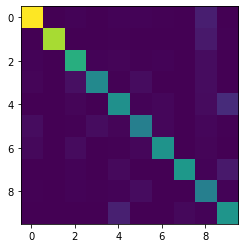

In [27]:
#Modèle Bernoulli

#On récupère P(x | theta)
vraiss = learnBernoulli(X_train, Y_train)
#A partir de P(x | theta) et des probas à priori on calcule la loi jointe
jointe = np.zeros(vraiss.shape)
print(np.sum(jointe))
for c in range(len(jointe)):
    for pix in range(len(jointe[0])):
        jointe[c][pix] = p[c]*vraiss[c][pix]
#On en déduit P(x)
pX = np.sum(jointe, axis=1)
#On en déduit l'à posteriori
posteriori = np.zeros(jointe.shape)
for c in range(len(jointe)):
    for pix in range(len(jointe[0])):
        posteriori[c][pix]=jointe[c][pix]/pX[c]
print(posteriori)


#Vérifier gain performance pour le modèle bernoulli  

Y_test_hat = [np.argmax(logpobsBernoulli(Xb_test[i], posteriori)) for i in range (len(Xb_test))]

m = matrice_confusion(Y_test, Y_test_hat)

print("\nTaux de bonne classification: {}".format(np.where(Y_test == Y_test_hat, 1, 0).mean()))

plt.figure()
plt.imshow(m)

[[0.02074815 0.02738635 0.03403985 0.04099845 0.05054323 0.06279906
  0.07600464 0.08829801 0.09914396 0.10670238 0.10687574 0.09384025
  0.07569852 0.05562961 0.03732313 0.02396867]
 [0.06047003 0.06189719 0.06207441 0.06202705 0.06221692 0.06236008
  0.06251592 0.06284209 0.06300035 0.06329463 0.06361655 0.06408036
  0.0641942  0.06395434 0.06245589 0.05899997]
 [0.0278439  0.04151504 0.06006892 0.06081834 0.04567402 0.03439496
  0.02866246 0.02973151 0.03970721 0.06398052 0.109452   0.1557069
  0.14402888 0.08460976 0.04595555 0.02785001]
 [0.06195986 0.08614685 0.08086342 0.05107722 0.0414     0.04470725
  0.05430409 0.05628843 0.04594838 0.03606426 0.03496993 0.04455361
  0.07046251 0.11627894 0.10555035 0.06942491]
 [0.03246675 0.041453   0.05331459 0.06646135 0.08659127 0.09995071
  0.11025008 0.10897404 0.09254938 0.07061518 0.05102253 0.04110313
  0.03760127 0.03672136 0.0365125  0.03441286]
 [0.03327423 0.04579737 0.05934745 0.07012457 0.07944834 0.08441017
  0.08109405 0.067

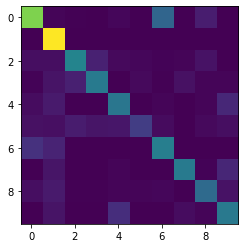

In [28]:
#Modèle géométrique

#On récupère P(x | theta)
vraiss = learnGeom(Xg_train, Y_train)

#A partir de P(x | theta) et des probas à priori on calcule la loi jointe
jointe = np.zeros(vraiss.shape)
for c in range(len(jointe)):
    for pix in range(len(jointe[0])): #1er pixel allumé de la ligne
        jointe[c][pix] = p[c]*vraiss[c][pix]

        #On en déduit P(x)
pX = np.sum(jointe, axis=1)

#On en déduit l'à posteriori
posteriori = np.zeros(jointe.shape)
for c in range(len(jointe)):
    for pix in range(len(jointe[0])):
        posteriori[c][pix]=jointe[c][pix]/pX[c]
print(posteriori)


#Vérifier gain performance pour le modèle géométrique 

Y_train_hat = [np.argmax(logpobsGeom(Xg_train[i], theta)) for i in range (len(Xg_train))]
m = matrice_confusion(Y_train, Y_train_hat)

print("\nTaux de bonne classification: {}".format(np.where(Y_train == Y_train_hat, 1, 0).mean()))

plt.figure()
plt.imshow(m)

# E. Fusion de modèle

Réussirez-vous à fusionner les sorties des modèles précédents pour améliorer la performance globale en test?
* En faisant voter les classifieurs
* En pondérant ces votes par leurs performances en apprentissage
* En fusionnant les vraisemblances

<span style="color:blue">
Ici on a observé que le classifieur selon le modèle Bernoulli était meilleur que celui selon le modèle géométrique.   
    
Il serait possible de faire quatre modèles géométriques (un par axe) afin d'améliorer ce modèle. 
    
</span>

<span style="color:blue">
Vote des classifieurs : 
</span>

In [39]:
# Prédiction selon ML
pMu, pSig = learnML_parameters(X_train, Y_train)
Y_train_hat_ML = classify_all_images(X_train, pMu, pSig, -1)

# Prédiction selon Bernoulli
pB = learnBernoulli(Xb_train, Y_train)
Y_train_hat_B = [np.argmax(logpobsBernoulli(Xb_train[i], pB)) for i in range (len(Xb_train))]

# Prédiction selon la loi géométrique 
pG = learnGeom(Xg_train, Y_train)
Y_train_hat_G = [np.argmax(logpobsGeom(Xg_train[i], pG)) for i in range (len(Xg_train))]

In [53]:
# Prédiction suite à un vote pondéré 

# Récupère les performances de chaque modèle pour avoir la bonne pondération 
perf_ML = np.where(Y_train_hat_ML == Y_train, 1, 0).mean()
perf_B = np.where(Y_train_hat_B == Y_train, 1, 0).mean()
perf_G = np.where(Y_train_hat_G == Y_train, 1, 0).mean()

prediction = []
for i in range(len(Y_train_hat_ML)): #pour chaque image
    predImage = np.zeros(10) #il y a dix classes possibles (chaque modèle va voter pour une classe avec un certains poids)
    predImage[Y_train_hat_ML[i]] += perf_ML 
    predImage[Y_train_hat_B[i]] += perf_B
    predImage[Y_train_hat_G[i]] += perf_G
    prediction.append(np.argmax(predImage)) #l'image est de la classe qui semble la meilleure selon les trois modèles



Taux de bonne classification: 0.8489324129073688


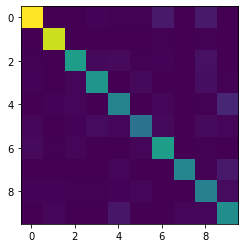

In [52]:
#Résultats
m = matrice_confusion(Y_train, prediction)
print("\nTaux de bonne classification: {}".format(np.where(Y_train == prediction, 1, 0).mean()))
plt.figure()
plt.imshow(m)

# F. Proposer une modélisation en 16 niveaux de gris basées sur une loi multinomiale